# *Model:* ARMA
# *Stock Data:* NSEI
# *Name: *Abbas Amjherawala**

In [1]:
#install arch module
!pip install arch

#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from arch import arch_model
from datetime import datetime, timedelta, timezone
from time import time
import warnings
from statsmodels.tsa.stattools import acf, pacf

#ignore warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.7/903.7 kB 13.6 MB/s eta 0:00:00a 0:00:01


In [2]:
#read input csv data
_df = pd.read_csv('/kaggle/input/nsei-prev-data/in_nsei_daily.csv', index_col='minute', parse_dates=True)
_df = _df.interpolate()
train_data = _df[:'2020-12-31']
test_data = _df['2021-01-01':]
print(train_data)
print(test_data)

                          ticker    instrument_token      open      high  \
minute                                                                     
2017-01-02 09:15:00+05:30   NSEI  uf-n-1647516806122   8211.70   8211.70   
2017-01-03 09:15:00+05:30   NSEI  uf-n-1647516806122   8195.25   8219.00   
2017-01-04 09:15:00+05:30   NSEI  uf-n-1647516806122   8201.60   8218.45   
2017-01-05 09:15:00+05:30   NSEI  uf-n-1647516806122   8227.75   8282.55   
2017-01-06 09:15:00+05:30   NSEI  uf-n-1647516806122   8283.50   8306.50   
...                          ...                 ...       ...       ...   
2020-12-24 09:15:00+05:30   NSEI  uf-n-1647516806122  13643.95  13771.75   
2020-12-28 09:15:00+05:30   NSEI  uf-n-1647516806122  13824.40  13885.30   
2020-12-29 09:15:00+05:30   NSEI  uf-n-1647516806122  13915.50  13967.60   
2020-12-30 09:15:00+05:30   NSEI  uf-n-1647516806122  13982.90  13997.00   
2020-12-31 09:15:00+05:30   NSEI  uf-n-1647516806122  13978.25  14024.85   

           

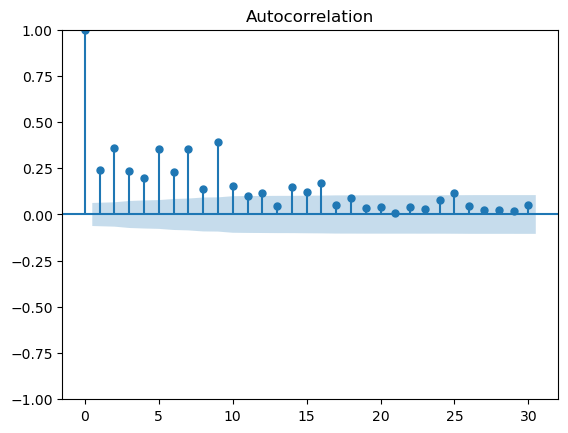

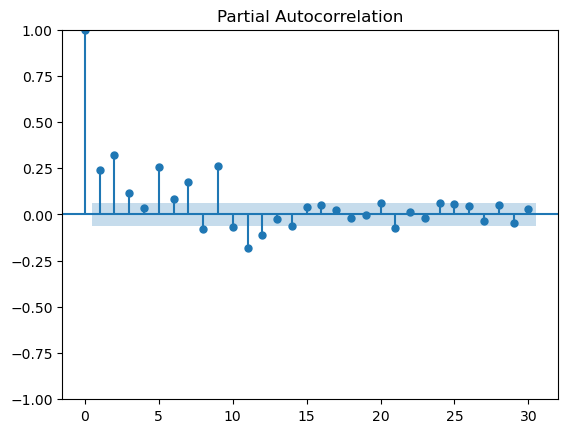

MA(q) order: 9
AR(p) order: 2


In [3]:
#calculate returns and plot ACF and PACF
returns = train_data['close'].pct_change().dropna()

plot_acf(returns**2)
plt.show()

plot_pacf(returns**2)
plt.show()

acf_values = acf(returns**2, nlags=20, fft=False)
sorted_indices = np.argsort(acf_values)
q = sorted_indices[-2]
print('MA(q) order:', q)

pacf_values = pacf(returns**2, nlags=20)
sorted_indices = np.argsort(pacf_values)
p = sorted_indices[-2]
print('AR(p) order:', p)

In [15]:
model = arch_model(returns, p=2, q=9)
results = model.fit()
forecast_horizon = 1
forecasts = results.forecast(horizon=forecast_horizon)
predicted_volatility = np.sqrt(forecasts.variance.iloc[-1])
last_price = train_data['2020-12-31'].close[0]
predicted_price = last_price * np.exp(predicted_volatility * np.random.normal())
print(predicted_price)

Iteration:      1,   Func. Count:     15,   Neg. LLF: 5711248543.509736
Iteration:      2,   Func. Count:     36,   Neg. LLF: 8.481593866550449e+19
Iteration:      3,   Func. Count:     57,   Neg. LLF: 1322917082.149961
Iteration:      4,   Func. Count:     78,   Neg. LLF: 259315693.3222078
Iteration:      5,   Func. Count:     99,   Neg. LLF: 120240.48475832987
Iteration:      6,   Func. Count:    120,   Neg. LLF: 2111008.9084413936
Iteration:      7,   Func. Count:    141,   Neg. LLF: -3261.5915527187735
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3261.5915562072396
            Iterations: 11
            Function evaluations: 141
            Gradient evaluations: 7
h.1    14054.849695
Name: 2020-12-31 09:15:00+05:30, dtype: float64


In [16]:
## predict data using model and input manual order (1,0)
import pytz
data_=[]
index_ = test_data.index.tolist()
index_.insert(0, pd.Timestamp('2020-12-31 09:15:00+05:30', tz=pytz.FixedOffset(330)))

try:
    for i in range(1,len(index_)):
        
        returns = train_data['close'].pct_change().dropna()
        model = arch_model(returns, p=2, q=9)
        results = model.fit()
        forecast_horizon = 1
        forecasts = results.forecast(horizon=forecast_horizon)
        predicted_volatility = np.sqrt(forecasts.variance.iloc[-1])
        last_price = train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]
        predicted_price = last_price * np.exp(predicted_volatility * np.random.normal())
        
        train_data.loc[index_[i]] = test_data.loc[index_[i]]            
        if predicted_price[0]<train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]:
            direction='SELL'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': train_data[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': train_data[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': predicted_price[0], 'Pnl':train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]-train_data[index_[i].strftime('%Y-%m-%d')].close[0]})
        else:
            direction='BUY'
            data_.append({'Date': index_[i-1].strftime('%Y-%m-%d'),'Day': index_[i-1].strftime('%A'), 'Current Close Price': train_data[index_[i-1].strftime('%Y-%m-%d')].close[0],'Next Day Price': train_data[index_[i].strftime('%Y-%m-%d')].close[0],'Predicted Direction' : direction,'Predicted Value': predicted_price[0], 'Pnl':train_data[index_[i].strftime('%Y-%m-%d')].close[0]-train_data[index_[i-1].strftime('%Y-%m-%d')].close[0]})

    
except KeyboardInterrupt or ValueError:
    print("Output is Stored in csv file: NSEI_STOCK.CSV!")

Iteration:      1,   Func. Count:     15,   Neg. LLF: 5711248543.509736
Iteration:      2,   Func. Count:     36,   Neg. LLF: 8.481593866550449e+19
Iteration:      3,   Func. Count:     57,   Neg. LLF: 1322917082.149961
Iteration:      4,   Func. Count:     78,   Neg. LLF: 259315693.3222078
Iteration:      5,   Func. Count:     99,   Neg. LLF: 120240.48475832987
Iteration:      6,   Func. Count:    120,   Neg. LLF: 2111008.9084413936
Iteration:      7,   Func. Count:    141,   Neg. LLF: -3261.5915527187735
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3261.5915562072396
            Iterations: 11
            Function evaluations: 141
            Gradient evaluations: 7
Iteration:      1,   Func. Count:     15,   Neg. LLF: 5748062924.175948
Iteration:      2,   Func. Count:     36,   Neg. LLF: 3229221240.799447
Iteration:      3,   Func. Count:     57,   Neg. LLF: 1360805374.386028
Iteration:      4,   Func. Count:     78,   Neg. LLF: 5824725

In [17]:
import csv
import os

headers = ['Date', 'Day', 'Current Close Price', 'Next Day Price','Predicted Direction', 'Predicted Value','Pnl']

if os.path.exists('/kaggle/working/nsei_stock.csv'):
    with open('nsei_stock.csv', mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        for row in data_:
            writer.writerow(row)
else:
    with open('nsei_stock.csv', mode='w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers)
        writer.writeheader()
        for row in data_:
            writer.writerow(row)


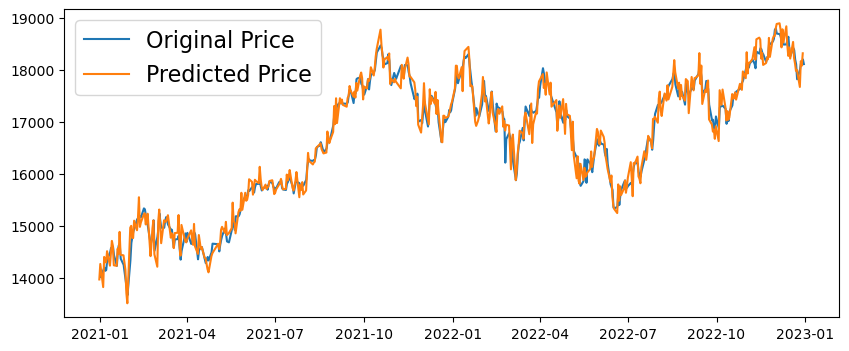

In [19]:
#plot graph between original and predicted
_df = pd.read_csv('/kaggle/working/nsei_stock.csv', index_col='Date', parse_dates=True)
plt.figure(figsize=(10,4))

plt.plot(test_data.close)
plt.plot(_df['Predicted Value'])
plt.legend(('Original Price', 'Predicted Price'), fontsize=16)